<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col, udf, split, mean
from pyspark.sql import Row, DataFrame

In [3]:
packages = ["org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.1",
            "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1"]
packages = ",".join(packages)

# master = "spark://localhost:7077"
master = "local"
appName = "sparkTest"

spark = SparkSession.builder \
                    .master(master) \
                    .appName(appName) \
                    .config("spark.jars.packages", packages) \
                    .getOrCreate()

spark

In [7]:
df = spark.read.option("header", "false").csv("hdfs://localhost:8020/data/task-event/").coalesce(2)

In [8]:
df.rdd.getNumPartitions()

1

In [4]:
df.show(10)

+-----+---+----+----------+---+------------+---+--------------------+---+---+-------------------+--------------------+--------------------+----+
|  _c0|_c1| _c2|       _c3|_c4|         _c5|_c6|                 _c7|_c8|_c9|               _c10|                _c11|                _c12|_c13|
+-----+---+----+----------+---+------------+---+--------------------+---+---+-------------------+--------------------+--------------------+----+
|10001|  0|null|3995607423|  3| 277452021.0|  0|01B/AOjE02qBWt8Yt...|  3|  9|0.19098993179863832| 0.19226796349329808| 0.06557736526267273| 0.0|
|10002|  0|null|3995607423|  4| 295000406.0|  0|01B/AOjE02qBWt8Yt...|  3|  9|0.18603381258694826| 0.09623108741740324| 0.18404858803890933| 0.0|
|10003|  0|null|3995607423|  5|3631105600.0|  0|01B/AOjE02qBWt8Yt...|  3|  9|0.14115545094812493|  0.1195550166641077|0.004743031960290524| 0.0|
|10004|  0|null|3995607423|  6| 294816869.0|  0|01B/AOjE02qBWt8Yt...|  3|  9|0.13896200897900945|  0.1887902584516184| 0.128120545

In [167]:
from pyspark.sql.functions import col

In [5]:
df_selected = df.select('_c9', '_c10', '_c11')
df_selected.show(3)

+---+-------------------+-------------------+
|_c9|               _c10|               _c11|
+---+-------------------+-------------------+
|  9|0.19098993179863832|0.19226796349329808|
|  9|0.18603381258694826|0.09623108741740324|
|  9|0.14115545094812493| 0.1195550166641077|
+---+-------------------+-------------------+
only showing top 3 rows



In [6]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, when

for c in df_selected.columns: 
    df_selected = df_selected.withColumn(c, col(c).cast("double"))

In [7]:
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml import Pipeline

In [8]:
stages = [] 
num_cols = ['_c10', '_c11']
imputed_cols = [col + "_imputed" for col in num_cols]
imputer = Imputer(inputCols=num_cols, outputCols=imputed_cols, strategy="mean")
    
feature_cols = [col for col in imputed_cols]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
gmm = GaussianMixture().setK(3).setSeed(538009335)
stages.append(imputer)
stages.append(vector_assembler)
stages.append(gmm)

pipeline = Pipeline(stages=stages)

In [9]:
%%time 
model = pipeline.fit(df_selected)

CPU times: user 34.8 ms, sys: 1.93 ms, total: 36.7 ms
Wall time: 20 s


In [10]:
model.transform(df_selected).show(n=3, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------
 _c9          | 9.0                                                           
 _c10         | 0.19098993179863832                                           
 _c11         | 0.19226796349329808                                           
 _c10_imputed | 0.19098993179863832                                           
 _c11_imputed | 0.19226796349329808                                           
 features     | [0.19098993179863832,0.19226796349329808]                     
 probability  | [0.021570673340295974,0.977892523210488,5.36803449215924E-4]  
 prediction   | 1                                                             
-RECORD 1---------------------------------------------------------------------
 _c9          | 9.0                                                           
 _c10         | 0.18603381258694826                                           
 _c11         | 0.09623108741740324                 

In [11]:
data = model.transform(df_selected).dropna()

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
extract_data = data.select(when(col("_c9") <= 3, "Free").when(col("_c9") <= 10, "Production").otherwise("Monitor").alias("priority"),
                           col("_c10").alias("cpu_request"), 
                           col("_c11").alias("memory_request"), 
                           col("prediction")).sample(fraction=0.05).toPandas()

In [24]:
extract_data.head()

,priority,cpu_request,memory_request,prediction
0,Production,0.064346,0.184820,0
1,Production,0.175883,0.091919,2
2,Production,0.098744,0.033469,2
3,Production,0.115225,0.199227,0
4,Production,0.084125,0.119564,0


In [25]:
gmm = model.stages[2]
gmm

GaussianMixtureModel: uid=GaussianMixture_378a6bea0a4d, k=3, numFeatures=2

In [26]:
gmm_coeff = gmm.gaussiansDF.rdd.map(lambda row: (row["mean"].toArray(), row["cov"].toArray())).collect()
means = [x[0] for x in gmm_coeff]
means

[array([0.08361899, 0.14673028]),
 array([0.18347778, 0.16581323]),
 array([0.16156232, 0.06420011])]

In [27]:
prediction_points = []
for index, frame in extract_data.groupby("prediction"): 
    prediction_points.append(frame.apply(lambda row: (row["cpu_request"], row["memory_request"]), axis=1))

In [28]:
priority_points = []
for index, frame in extract_data.groupby("priority"): 
    print(index)
    priority_points.append(frame.apply(lambda row: (row["cpu_request"], row["memory_request"]), axis=1))

Free
Monitor
Production


In [29]:
def plot_result(ax, points: pd.Series, color="r", label=None): 
    x = points.map(lambda r: r[0]).values
    y = points.map(lambda r: r[1]).values
    
    ax.scatter(x, y, color=color, label=label)
    ax.legend()

<AxesSubplot:xlabel='priority', ylabel='count'>

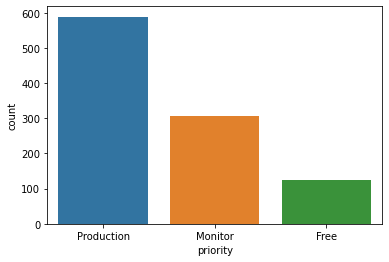

In [32]:
sns.countplot(data=extract_data, x="priority")

<AxesSubplot:xlabel='prediction', ylabel='count'>

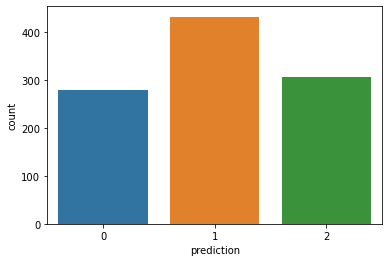

In [33]:
sns.countplot(data=extract_data, x="prediction")

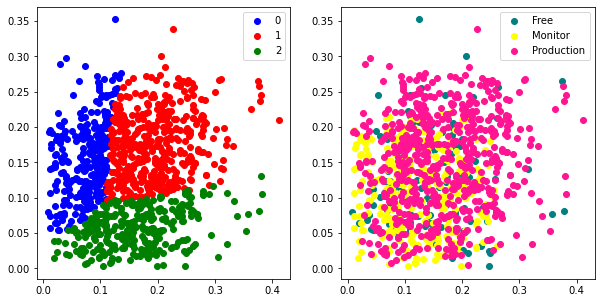

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_result(ax1, prediction_points[0], color="blue", label="0")
plot_result(ax1, prediction_points[1], color="red", label="1")
plot_result(ax1, prediction_points[2], color="green", label="2")
plot_result(ax2, priority_points[0], color="teal", label="Free")
plot_result(ax2, priority_points[1], color="yellow", label="Monitor")
plot_result(ax2, priority_points[2], color="deeppink", label="Production")

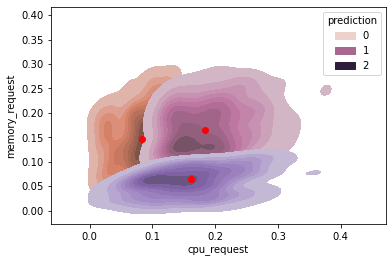

In [35]:
import seaborn as sns

plt.figure()
sns.kdeplot(data=extract_data, x="cpu_request", y="memory_request", hue="prediction", fill=True)
plt.scatter(x=[e[0] for e in means], y=[e[1] for e in means], color="red")

In [36]:
model.write().overwrite().save("hdfs://localhost:8020/data/model/pyspark/task-event_update")

In [38]:
from pyspark.ml import PipelineModel
m = PipelineModel.load("hdfs://localhost:8020/data/model/pyspark/task-event_update")
m

PipelineModel_858bba0ac520